##  0.0. BASE

### 0.1 DOWNLOAD

In [1]:
pip install jupyterlab scikit-plot requests xgboost

Note: you may need to restart the kernel to use updated packages.


### 0.2 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import inflection
import pickle

import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

from matplotlib import pyplot as plt
from IPython.core.display import HTML #expande celula python
from IPython.display import Image #adciona magem

import xgboost as xgb
from xgboost import XGBClassifier


!pip install imblearn

from sklearn.metrics import accuracy_score, f1_score,auc

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor

#train

You should consider upgrading via the '/home/arquinho/REPOS/health/projeto/bin/python -m pip install --upgrade pip' command.


In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    #define tasmanho celulas
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.3 LOADING DATASET

In [4]:
df_raw = pd.read_csv('/home/arquinho/REPOS/health/projeto/train.csv')

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.0 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()
df1.shape

(381109, 12)

### 1.1 RENAME COLUMNS

In [7]:
df1.columns
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

### 1.2 DATA DIMENSION

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Columns: 12


### 1.3 DATA TYPES

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.4 DATA NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.5 DATA DESCRIPTIVE

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat__attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [12]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [13]:
m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871


## 2.0. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

In [15]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year' )

#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

## 3.0. DATA FILTERING

In [16]:
df3 = df2.copy()

## 4.0. EDA

In [17]:
df4 = df3.copy()

### 4.1 UNIVARIATE ANALYSIS

In [18]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<AxesSubplot:xlabel='response', ylabel='age'>

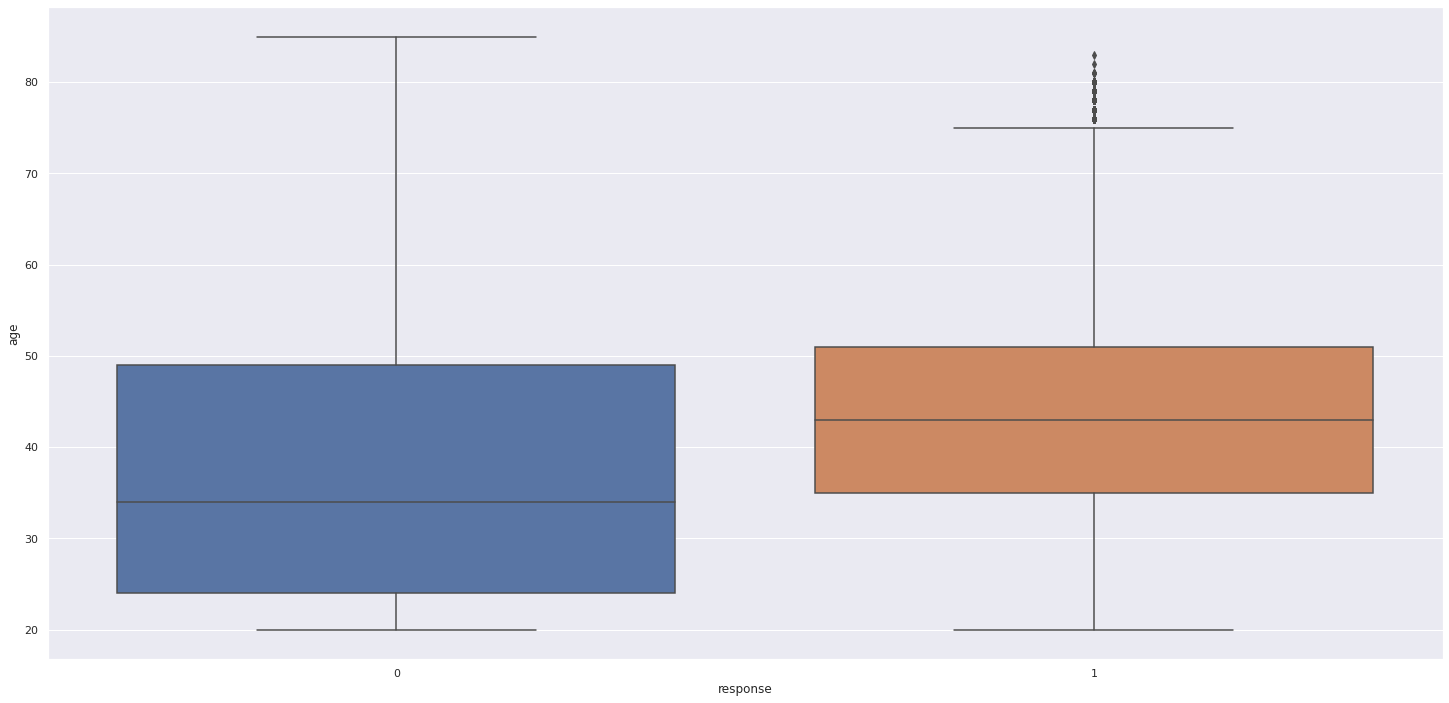

In [19]:
#age
sns.boxplot(x='response', y='age', data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

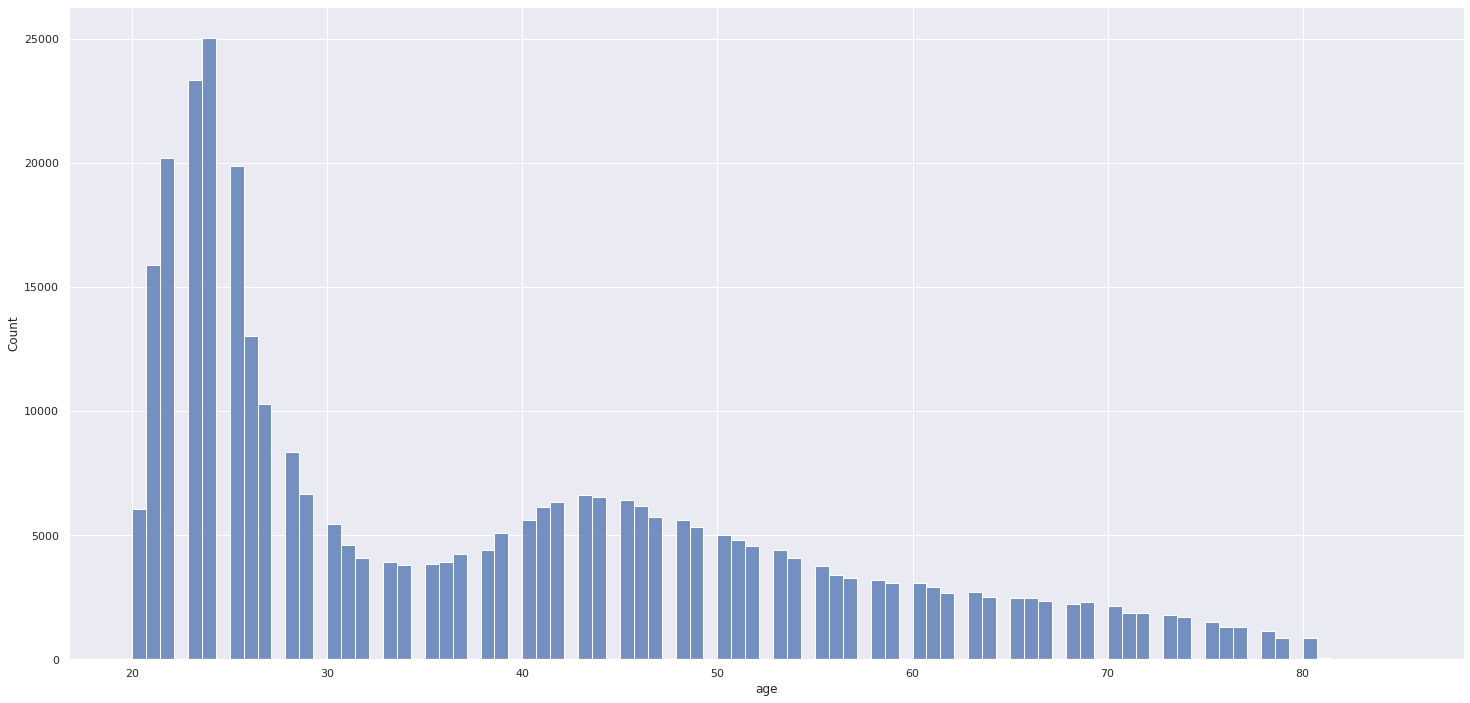

In [20]:
aux1 = df4.loc[df4['response'] ==0, 'age']
sns.histplot( aux1 )

<AxesSubplot:xlabel='age', ylabel='Count'>

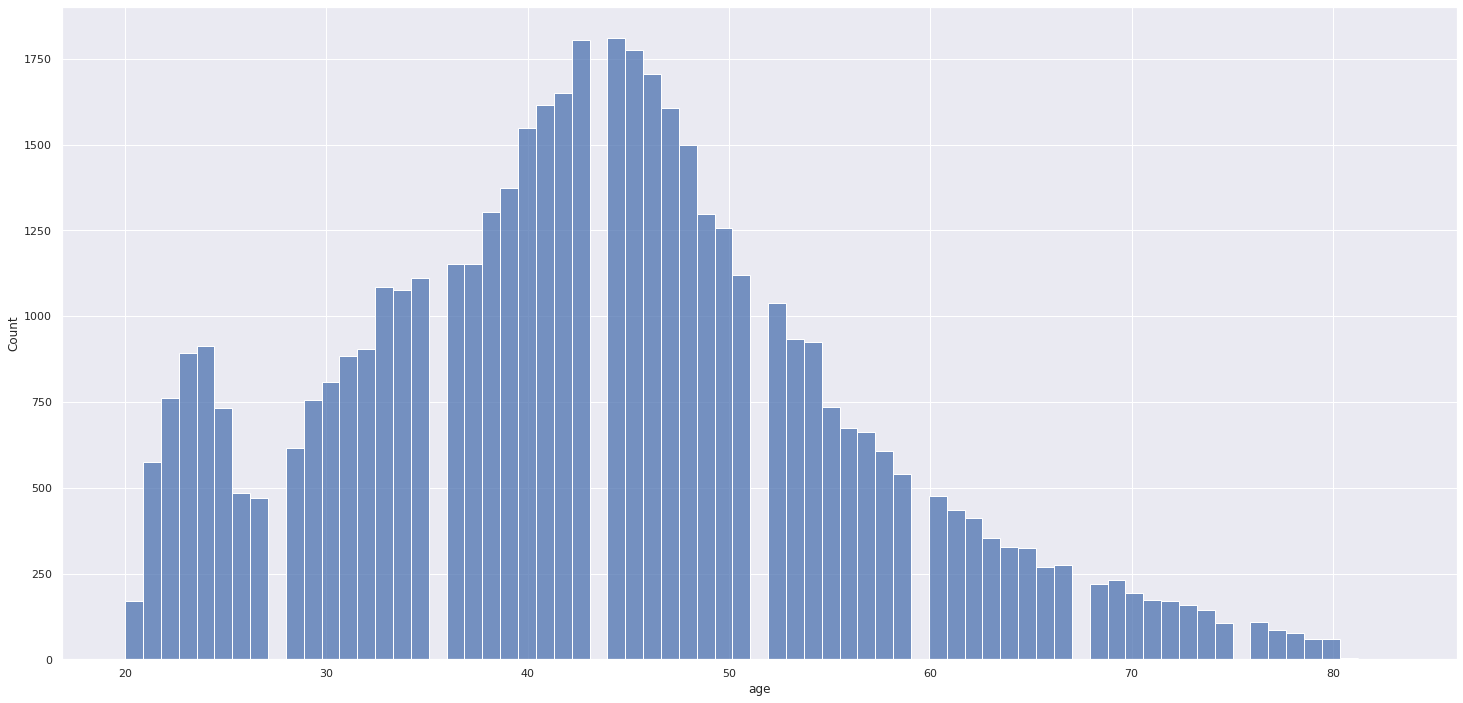

In [21]:
aux1 = df4.loc[df4['response'] ==1, 'age']
sns.histplot( aux1 )

In [22]:
#annual_premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

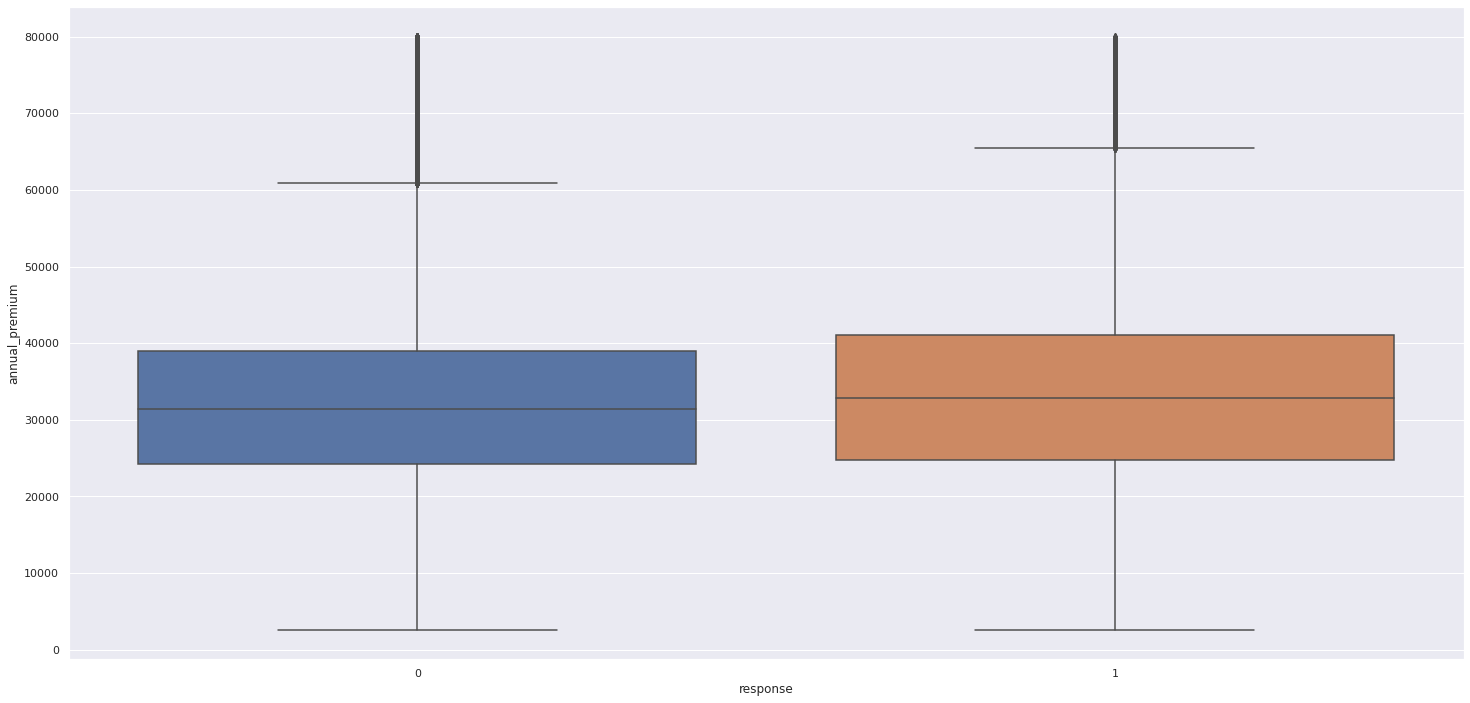

In [23]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data= aux) #bom para achar outlier

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

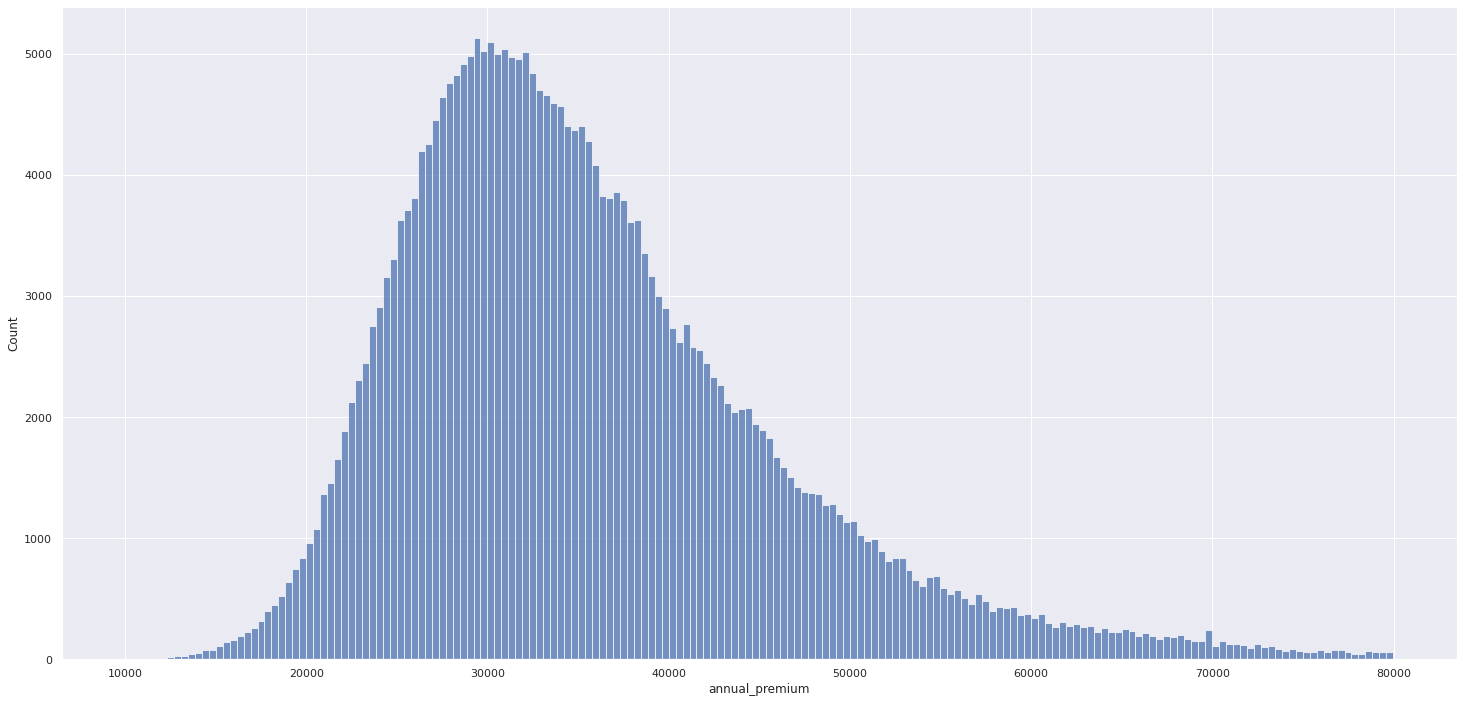

In [24]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] <80000 )]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux1 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

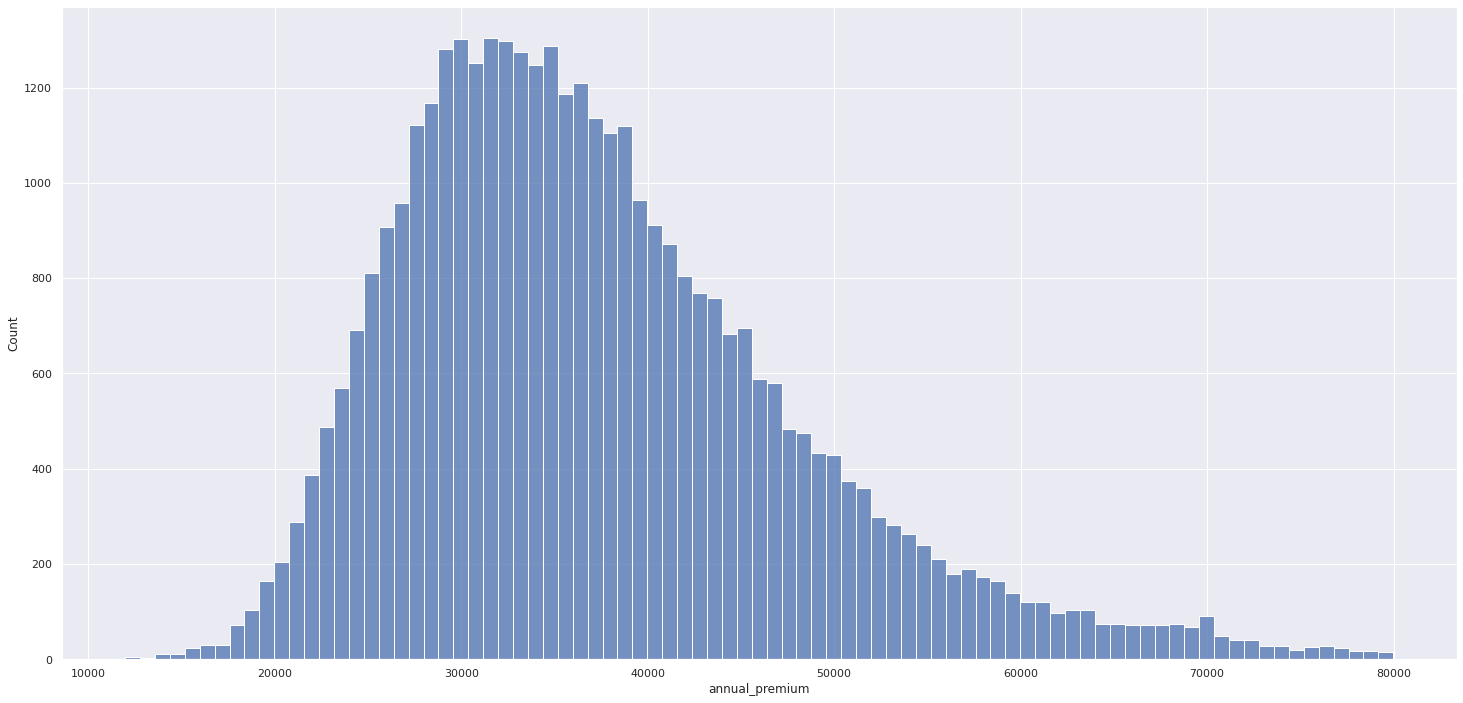

In [25]:
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux1 )

<AxesSubplot:xlabel='response', ylabel='driving_license'>

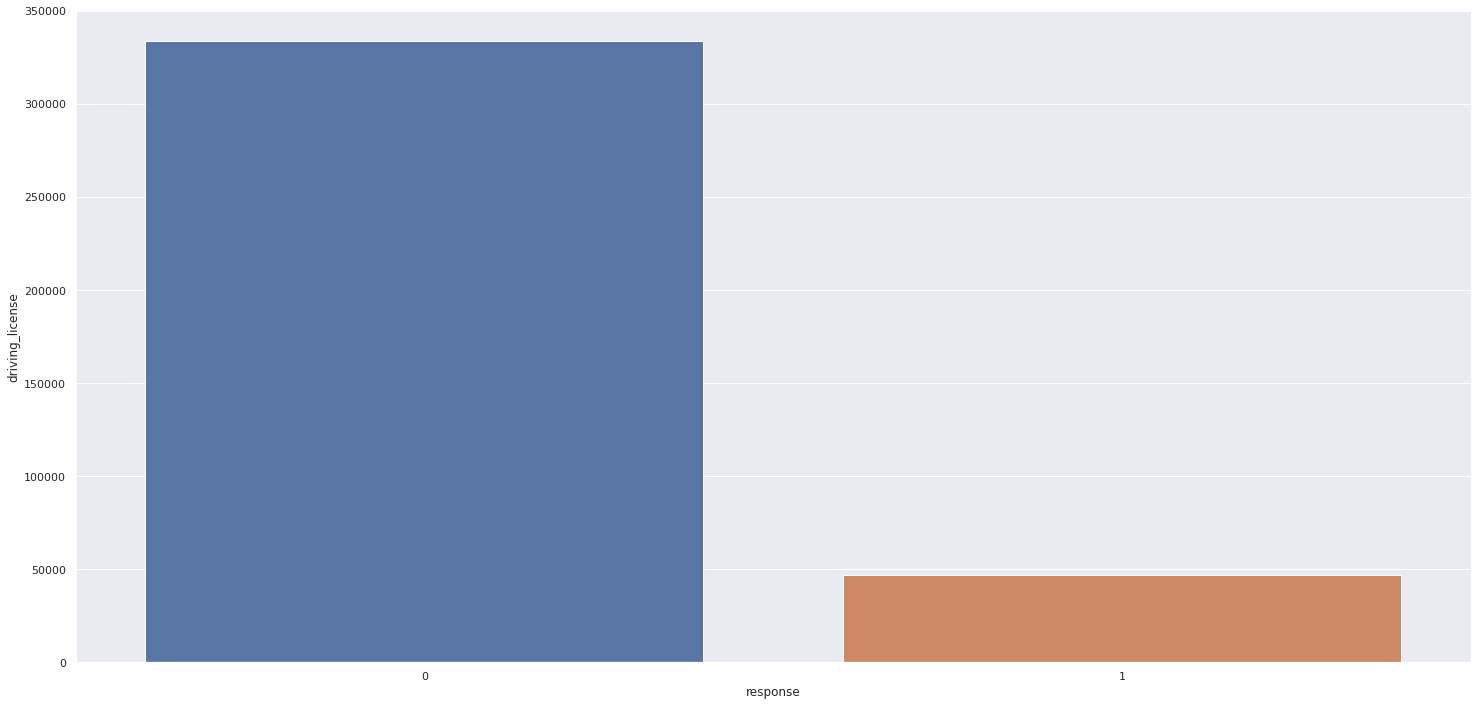

In [26]:
#driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux)

In [27]:
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

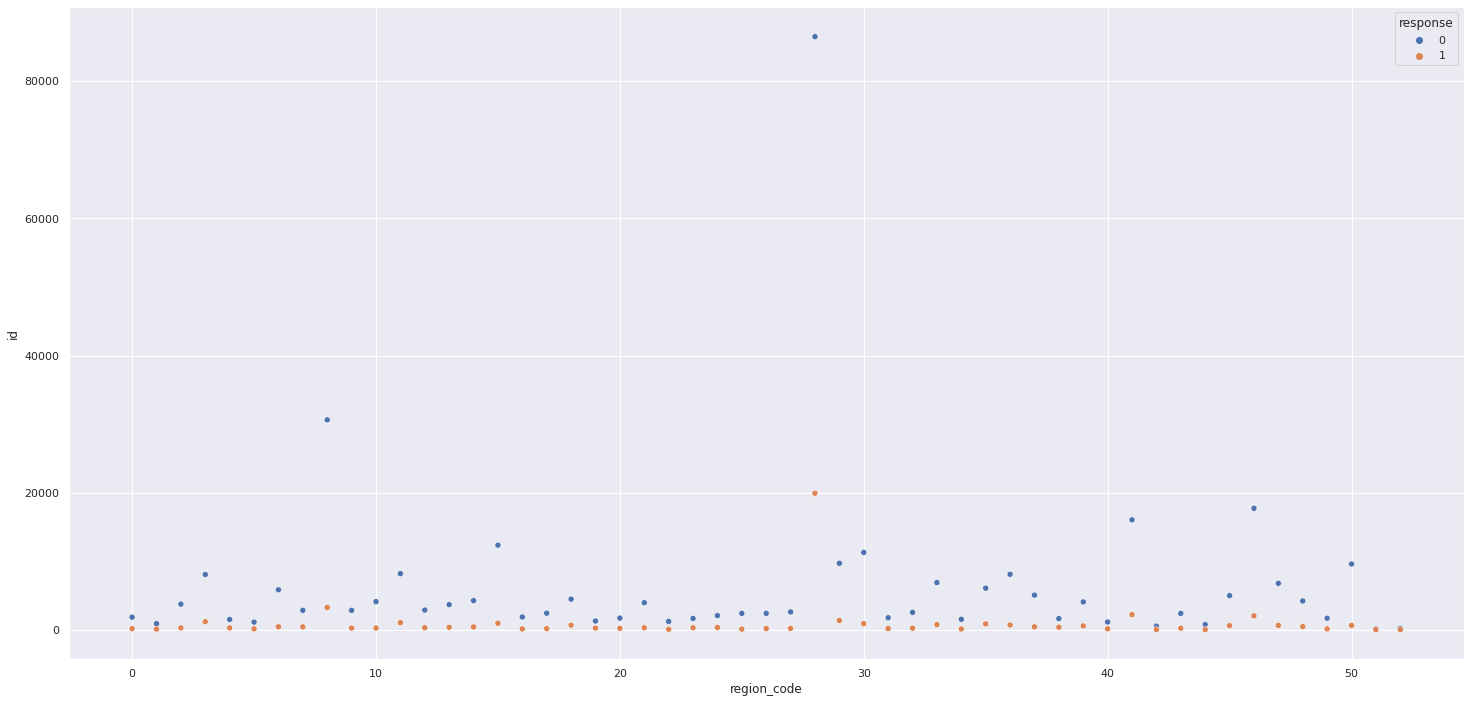

In [28]:
#region_code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux)

In [29]:
#previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [30]:
#vehicle_age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index() # Fa - Estat

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

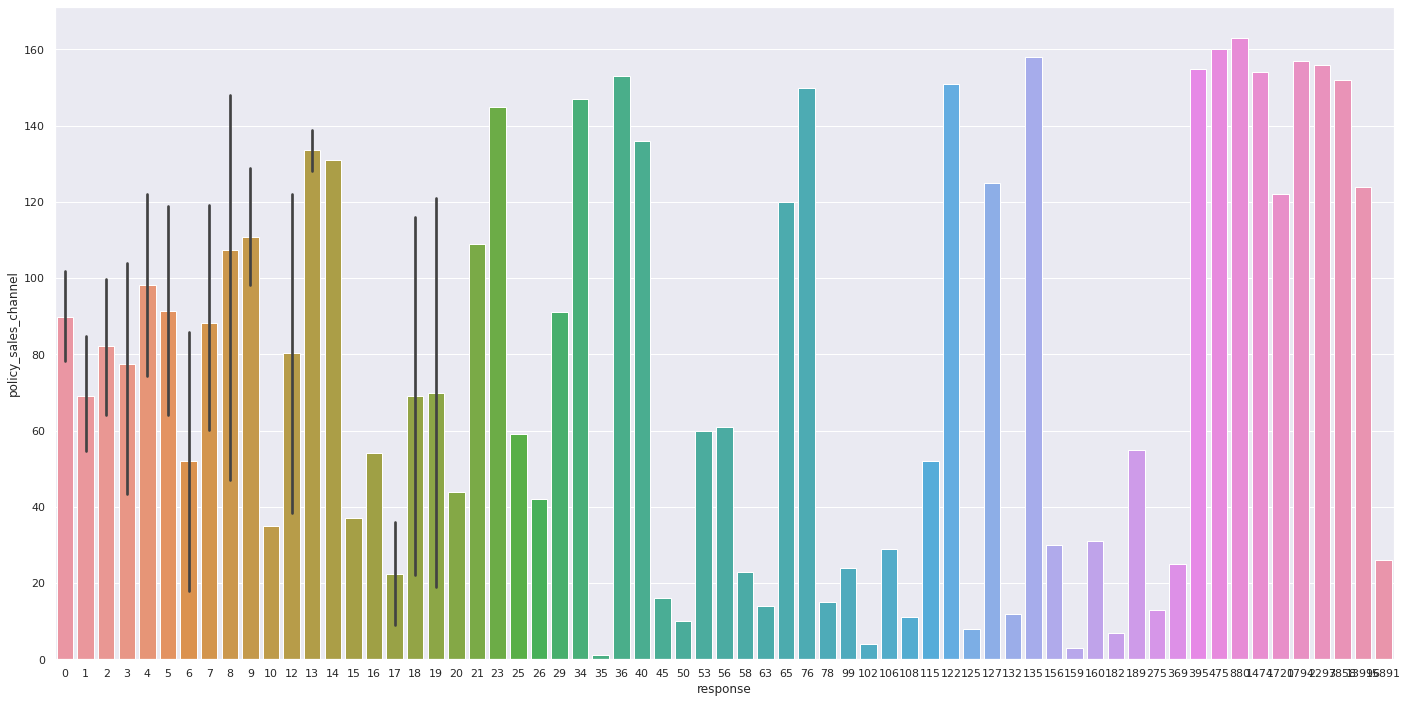

In [31]:
#policy_sales_channel
plt.figure( figsize=(24, 12)) #aumenta tamanmhop do grafo
aux= df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux)

<AxesSubplot:xlabel='response', ylabel='vintage'>

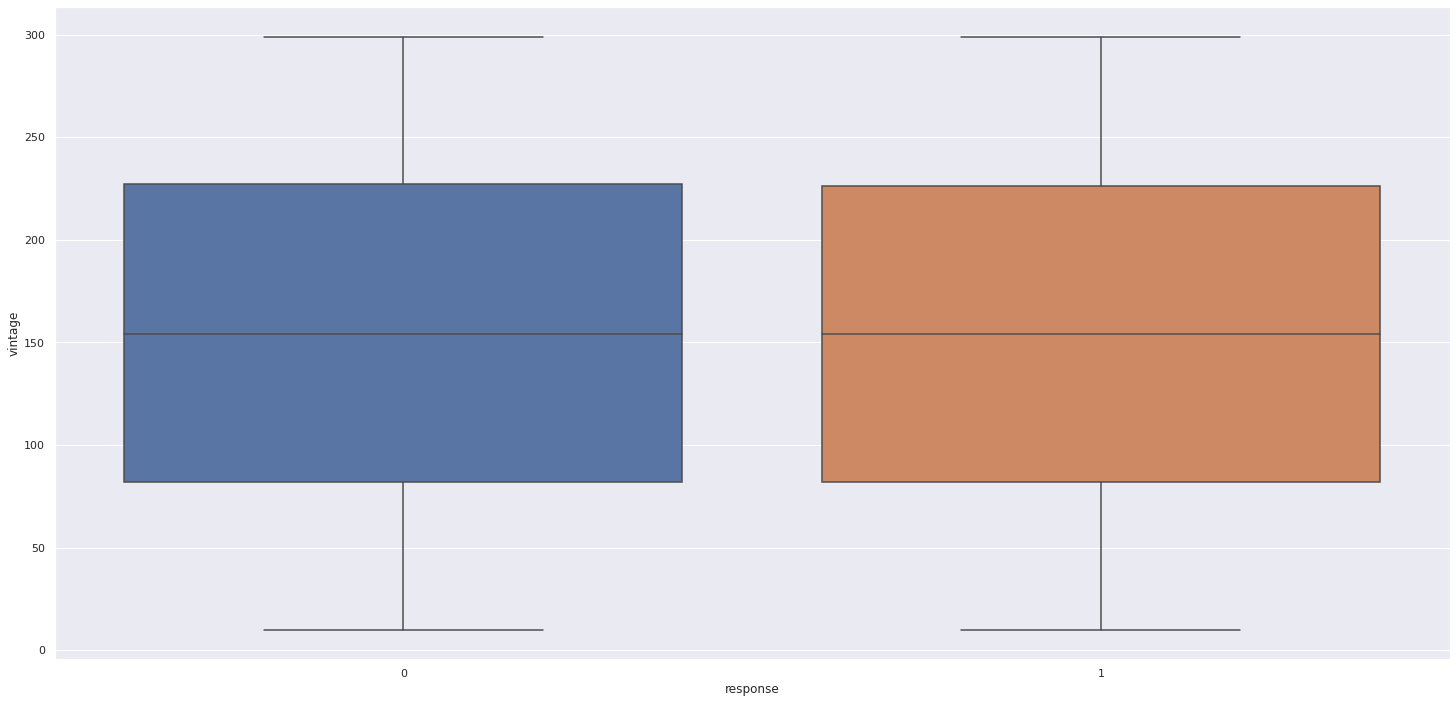

In [32]:
#vintage
sns.boxplot( x='response', y='vintage', data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

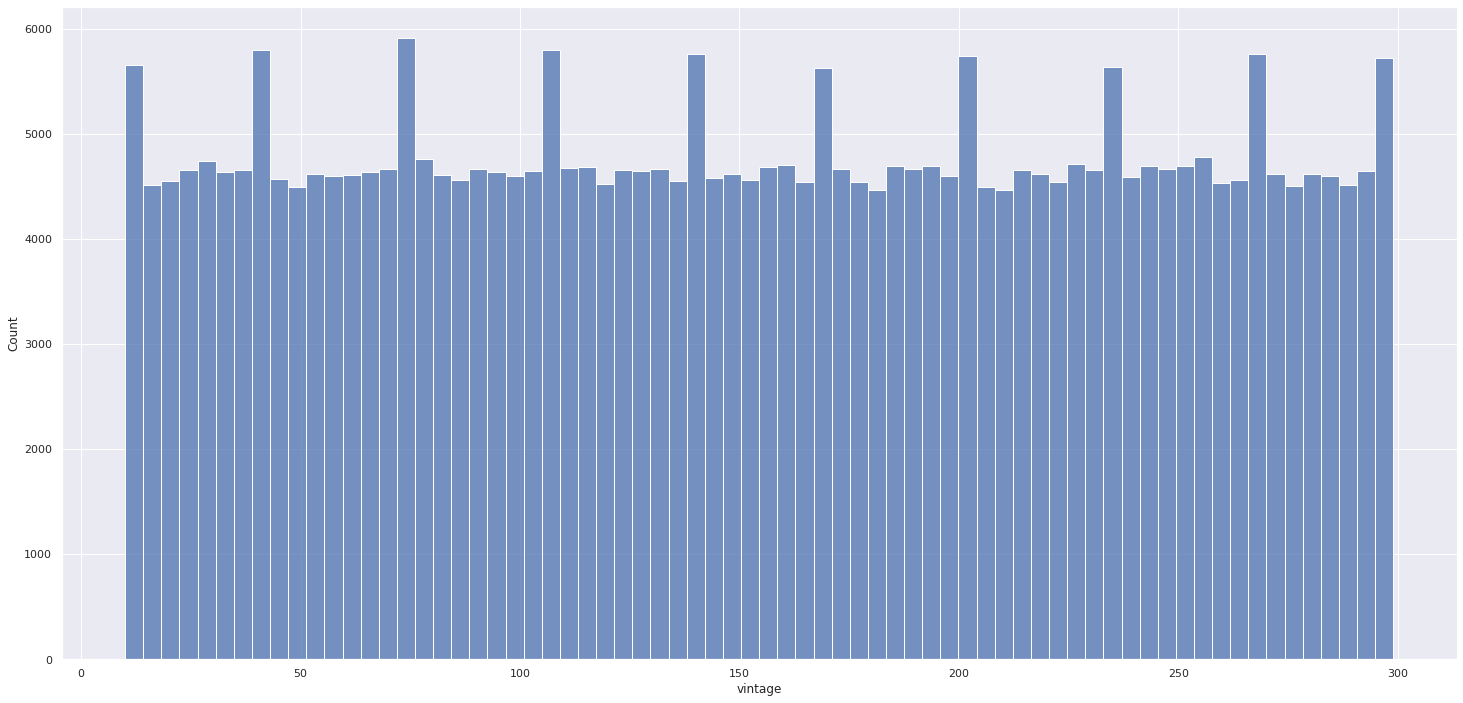

In [33]:
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

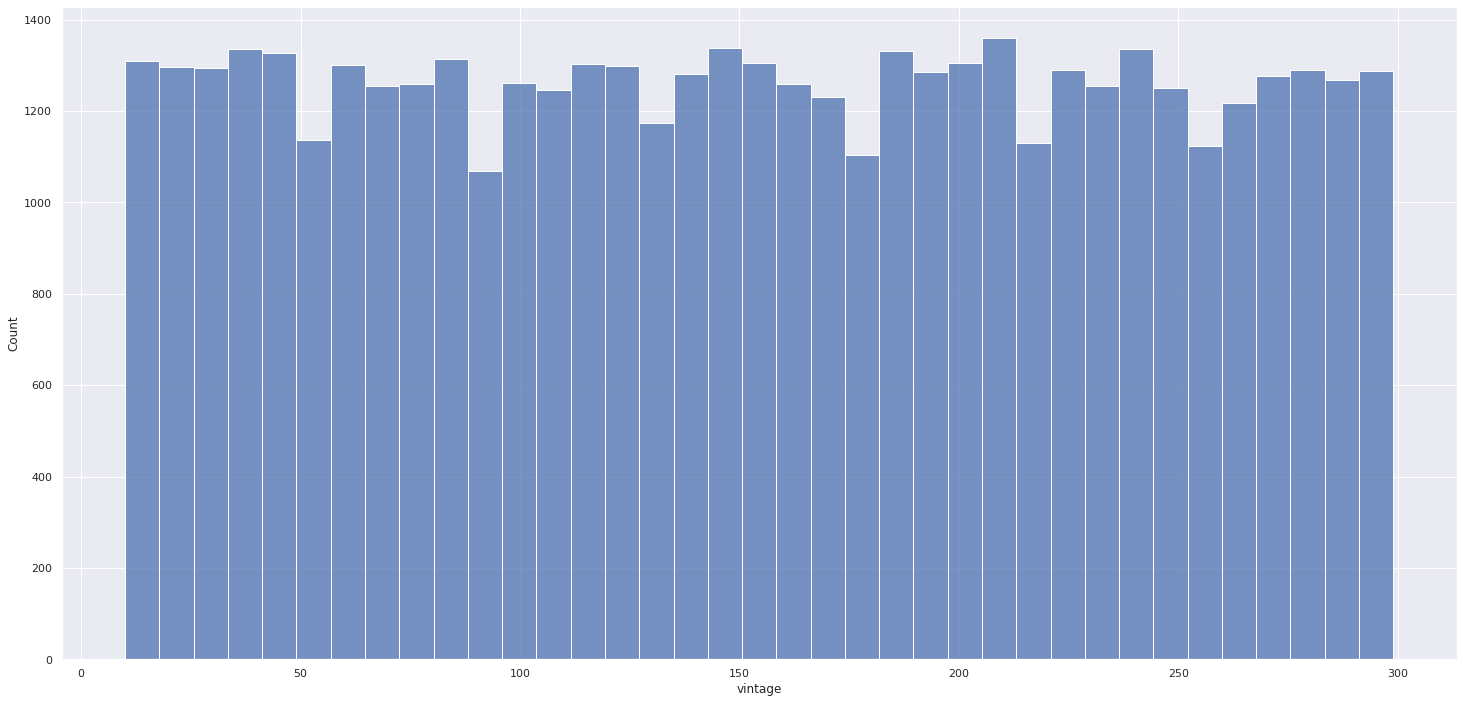

In [34]:
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux1 )

## 5.0. DATA PREPARATION

In [35]:
df5 = df4.copy()

In [36]:
X = df4.drop( 'response', axis=1 ) #independet variable
y = df4['response'].copy() #depedency variable that will be predicted

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20) #teste tera 20% e train 80%

df5 = pd.concat( [x_train, y_train], axis=1)

### 5.1 STANDARDIZSATION
media - devio padrao

In [37]:
ss = pp.StandardScaler()

#annual premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
# pickle.dump( ss, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/annual_premium_scaler.pkl', 'wb' ) )

###  5.2 RESCALING
reescalar os intervalos entre 0 e 1

In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df5['age'] = mms_age.fit_transform( df5[['age']].values)
# pickle.dump( mms_age, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/age_scaler.pkl', 'wb' ) )

#vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)
# pickle.dump( mms_vintage, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/vintage_scaler.pkl', 'wb' ) )

###  5.3 ENCODER

In [39]:
#gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
# pickle.dump(target_encode_gender, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/target_encode_gender_scaler.pkl', 'wb' ) )
#region code - target encond/ferquency/weighted #muitos valores para hot
# usa media da frequencia dos outros valores [ara atribui-los valores]
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
# pickle.dump(target_encode_region_code, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle age - One Hot / Order enconding/Frequency
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
#dummies transforma cat em onr hot. Pessimo quando se tem muitos valores diferrente spois deixa gigante o DF

#policy sales channel - Frequency Encoding/ target
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
# pickle.dump( fe_policy_sales_channel, open( '/home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

### 5.4 VALIDATION PREPARATION

In [40]:
#gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

#age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

#region code 
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

#annual premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

#policy sales channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

#vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

#fillna
x_validation = x_validation.fillna(0)

/home/arquinho/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/arquinho/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/arquinho/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy 

## 6.0. FEATURE SELECTION

In [41]:
df6 = df5.copy()

### 6.1 FEATURE IMPORTANCIA EXTRATREES
boruta retornava poucas variaveis

In [42]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1) #mais rapido que o random

#data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [43]:
x_train.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage'],
      dtype='object')

Feature Ranking:
                        feauture  importance
0                        vintage    0.271665
0                 annual_premium    0.244147
0                            age    0.165894
0                    region_code    0.106510
0                 vehicle_damage    0.067836
0           policy_sales_channel    0.060455
0             previously_insured    0.056521
0       vehicle_age_below_1_year    0.013538
0  vehicle_age_between_1_2_years    0.006068
0                         gender    0.004532
0       vehicle_age_over_2_years    0.002334
0                driving_license    0.000499


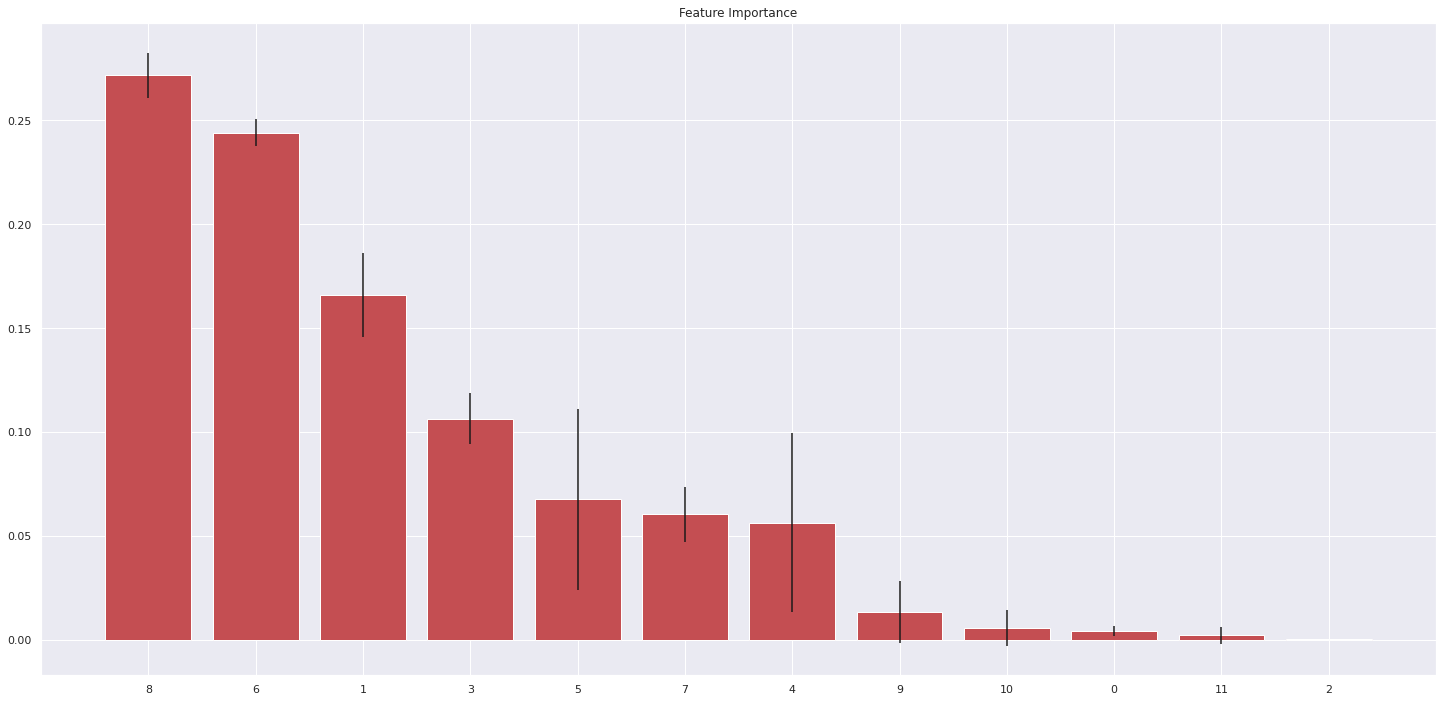

In [44]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

#printr the feature ranking
print("Feature Ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feauture': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis=0)
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-basew feature importances of forest
plt.figure()
plt.title("Feature Importance")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1] ), indices )
plt.xlim([ -1, x_train_n.shape[1]] )
plt.show()

## 7.0. MACHINE LEANING

In [45]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

### 7.1 REGRESSAO LOGISTICA

Train Performance:  0.8771741661664814
Test Performance:  0.8784865261997848


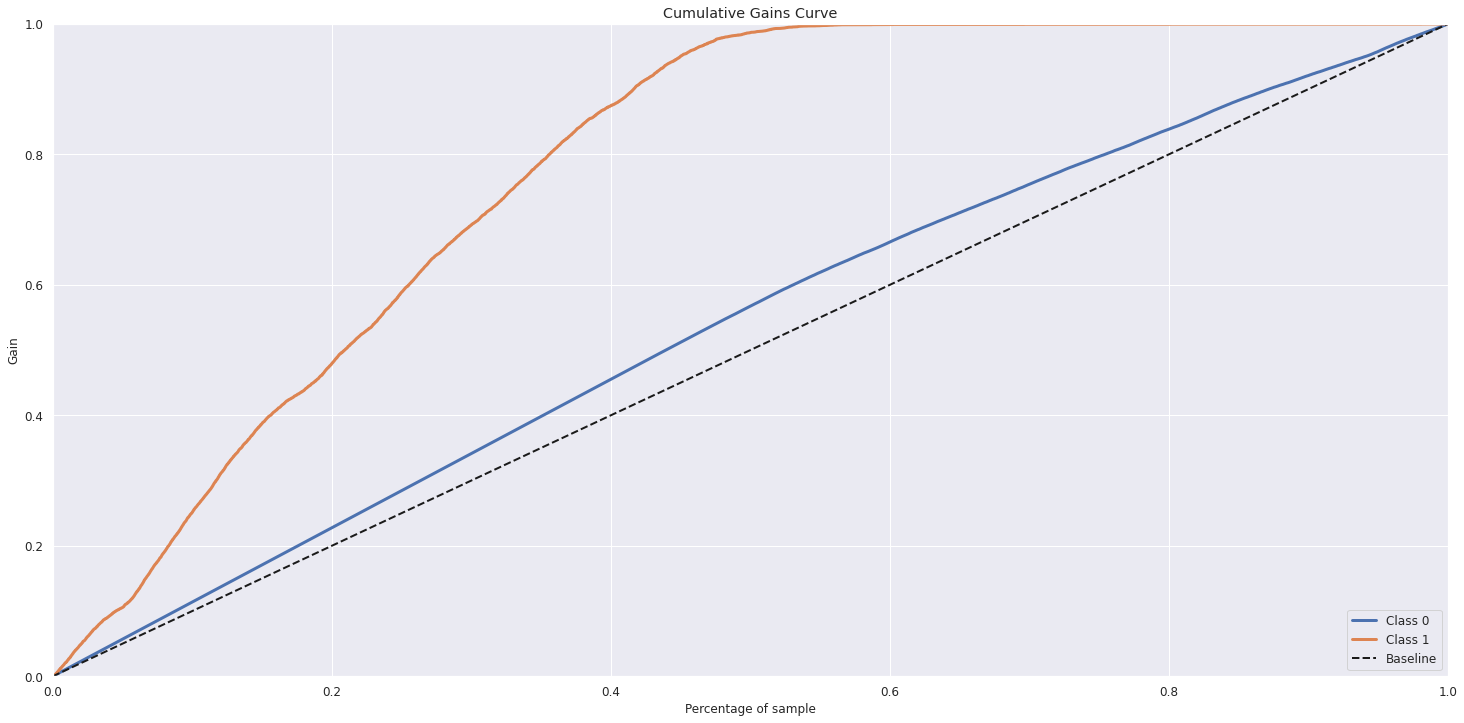

In [49]:
#model definition
lr_model = lm.LogisticRegression( max_iter=1000, random_state=42 )

#model training
lr_model.fit( x_train, y_train )

#model prediction
yhat_lr = lr_model.predict_proba( x_val )

# accumulative gain
print('Train Performance: ', lr_model.score(x_train, y_train))
print('Test Performance: ', lr_model.score(x_val, y_val))
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr);


### 7.2. KNN

In [46]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

#model training
knn_model.fit( x_train, y_train )

#model prediction - poder de generalizacao
yhat_knn = knn_model.predict_proba( x_val )

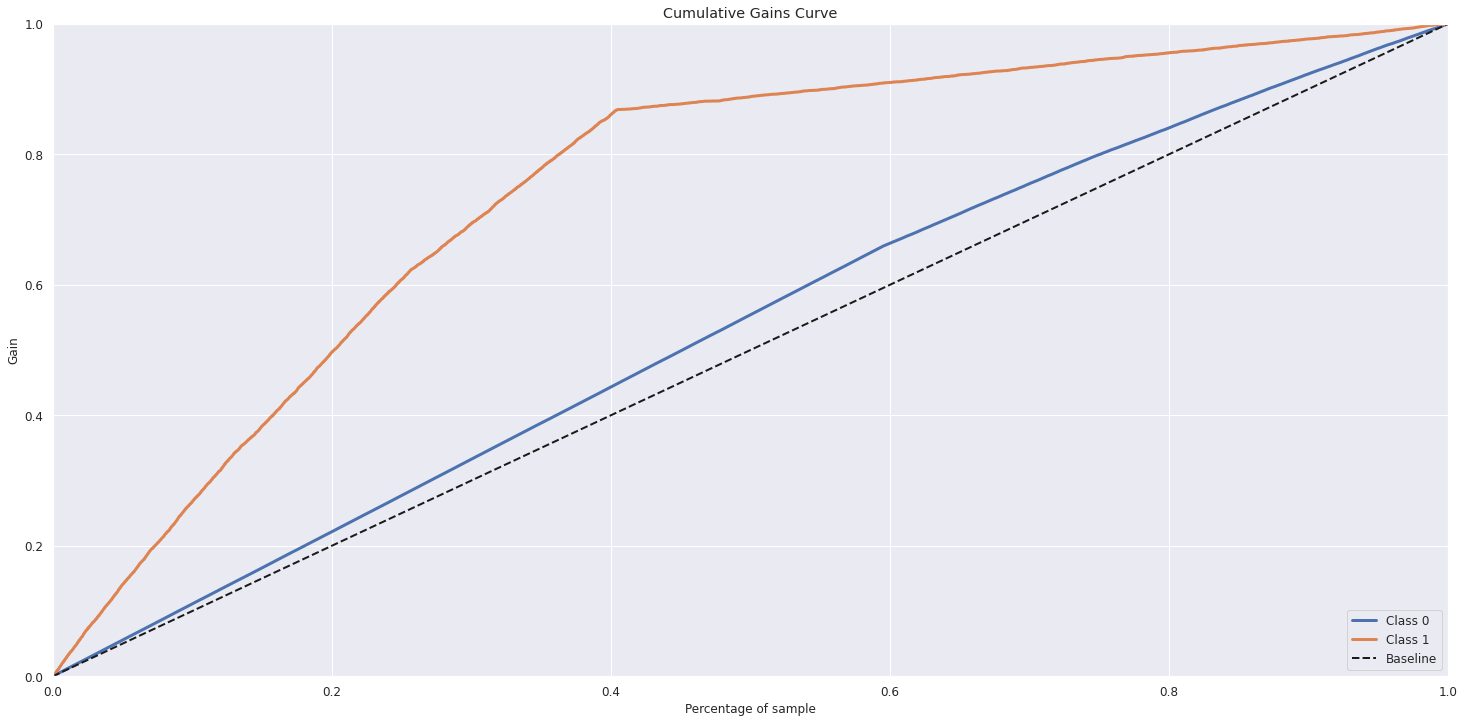

In [47]:
# Accumulative Gain - Metricas de ordenacao visto quie o objetivo e' ordenar os clientes e nao classificar quem tem
#mais probabilidade d comprar o produto
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn);

In [ ]:
skplt.metrics.plot_lift_curve(y_val, yhat_lr)

### 7.3 EXTRA TREES

Train Performance:  0.9996293708816709
Test Performance:  0.8623625724856341


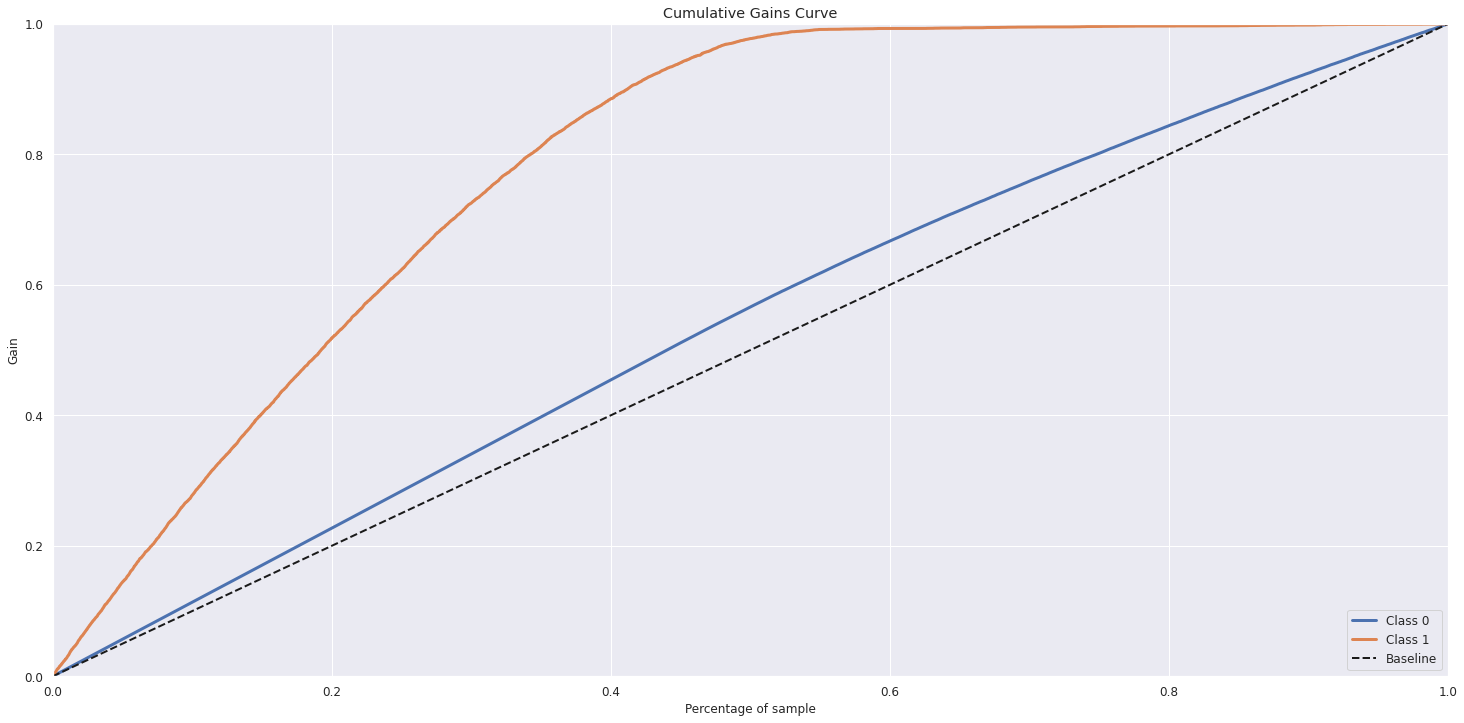

In [50]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=400, n_jobs=-1, random_state=42 )
    
# model fit
et.fit( x_train, y_train )
# #model prodict
yhat_et = et.predict_proba( x_val )


print('Train Performance: ', et.score(x_train, y_train))
print('Test Performance: ', et.score(x_val, y_val))

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et);

### 7.4. DECISION TREE 

Train Performance:  0.9996293708816709
Test Performance:  0.8255228149353205


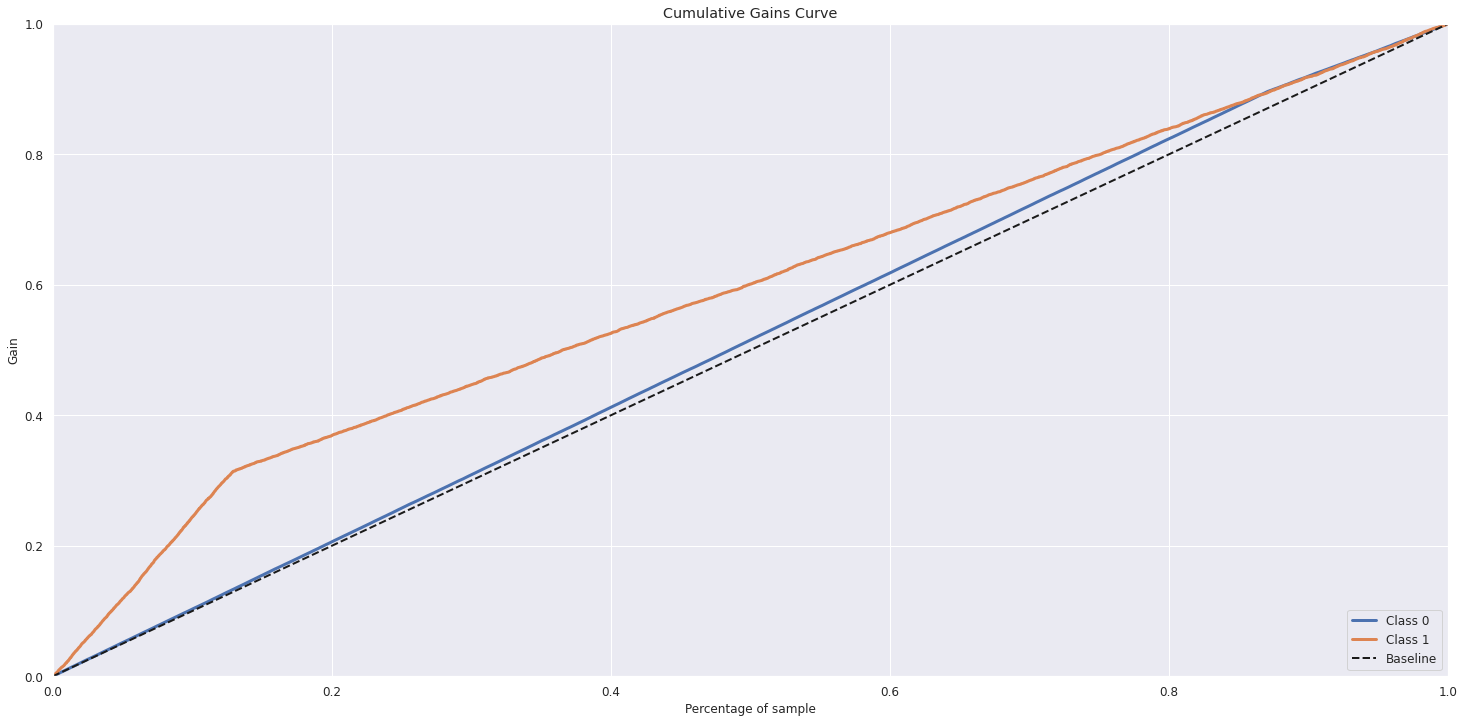

In [55]:
model_dt=DecisionTreeClassifier( random_state=40 ) 
             
# model fit
model_dt.fit( x_train, y_train )
             
# #model prodict
yhat_dt = model_dt.predict_proba( x_val )


print('Train Performance: ', model_dt.score(x_train, y_train))
print('Test Performance: ', model_dt.score(x_val, y_val))

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_dt);

### 7.5. XGBOOST

Train Accuracy: 87.94%
Test Accuracy: 87.80%


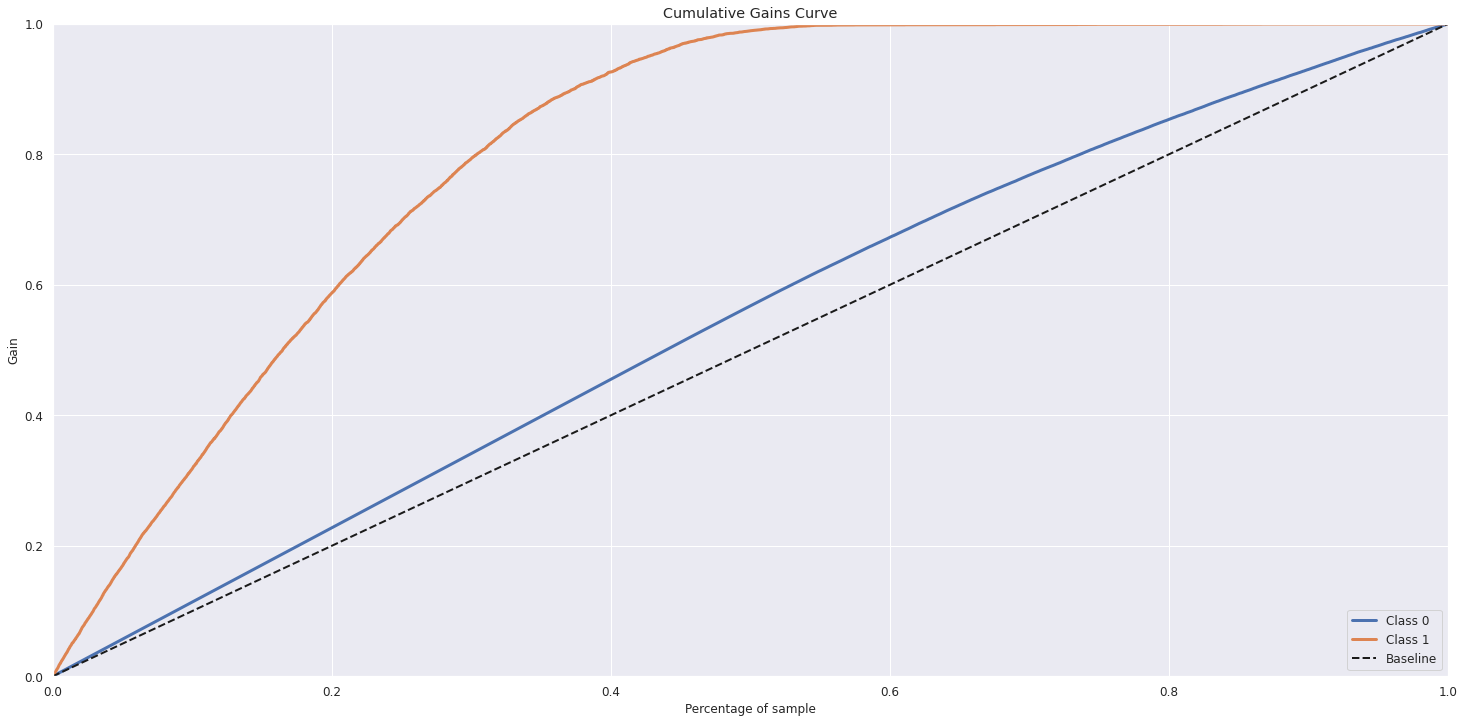

In [83]:
xgb = XGBClassifier(objective='binary:logistic', verbosity=0)
xgb.fit(x_train, y_train)
pred_proba_xgb = xgb.predict_proba(x_val)

#prediction
yhat_xgb1 = xgb.predict(x_train)

yhat_xgb2 = xgb.predict(x_val)
# # perfomance
# xgb_result = m1_error('XGBoost Regressor', np.expm1(y_test),
#                       np.expm1(yhat_xgb))


predictions1 = [round(value) for value in yhat_xgb1]

predictions2 = [round(value) for value in yhat_xgb2]


accuracy1 = accuracy_score(y_train, predictions1)
print("Train Accuracy: %.2f%%" % (accuracy1 * 100.0))

accuracy2 = accuracy_score(y_val, predictions2)
print("Test Accuracy: %.2f%%" % (accuracy2 * 100.0))

skplt.metrics.plot_cumulative_gain(y_val, pred_proba_xgb);


## 8.0. MODEL PERFORMANCE

In [ ]:
def precision_at_k( data, k=2000 ):
    #reset index
    data = data.reset_index( drop=True )
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [ ]:
def recall_at_k( data, k=2000 ):
    #reset index
    data = data.reset_index( drop=True )
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [ ]:
#copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sort ckients bu propensity score
df8 = df8.sort_values( 'score', ascending=False )

#compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print('Precision At K: {}'.format( precision_at_50 ) )

#compute recall at k
#compute precision at k
recall_at_50 = recall_at_k(df8, k=50)
print('Recall At K: {}'.format( recall_at_50 ) )

## 9.0. RECOMENDATION

In [ ]:
jkh

In [ ]:
df8 = df8.loc[df8['score'] >= 0.5].sort_values('score',ascending=False)
#df8 = df8.astype( int)
df8.shape

In [ ]:
gg=df3.copy()
gg.columns
gg.drop([ 'driving_license',  'previously_insured',  'vehicle_damage', 'annual_premium', 'response'], axis=1, inplace=True)
df8.drop([ 'gender', 'age', 'region_code', 'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years', 'vintage'], axis=1, inplace=True)


In [ ]:
df11 = pd.merge(gg, df8, how='left', on='id')
df11 = df11.dropna()


In [ ]:
df11 = df11.sort_values('score', ascending=False).reset_index()

In [ ]:
recomendation = df11.drop('index', axis=1)

In [ ]:
recomendation

In [ ]:
#recomendation.to_csv('/home/arquinho/REPOS/recomendation.csv')
gg= pd.read_csv('/home/arquinho/REPOS/recomendation.csv')
gg

## 10.0. DEPLOY MODEL TO PRODUCTION

In [ ]:
# saviing traioned model
# pickle.dump( lr_model, open( '//home/arquinho/REPOS/health_insurance/health_insurence_cross_sell/src/models/model_logistic_regression.pkl', 'wb' ) )

### 9.1. HEALTH INSURANCE CLASS

In [ ]:
import pandas as pd
import numpy as np
from inflection import underscore
import pickle

class HealthInsurance( object ):
    def __init__( self ):
        self.annual_premium_scaler             = pickle.load( open(  'features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler                        = pickle.load( open(  'features/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler                    = pickle.load( open(  'features/vintage_scaler.pkl', 'rb' ) )
        self.target_encode_gender_scaler       = pickle.load( open(  'features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler  = pickle.load( open(  'features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler    = pickle.load( open(  'features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1 ):
        df1.columns = [underscore(k) for k in df1.columns.tolist()]
        
        return df1
    
    def feature_engineering( self, df2 ):
        #vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                                      'between_1_2_years' if x == '1-2 Year' else 'below_1_year' )

        #vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        
        return df2
        
    def data_preparation(self, df3):
        #annual premium
        df3['annual_premium'] = self.annual_premium_scaler.transform( df3[['annual_premium']].values )
        #5.2 RESCALING
        #reescalar os intervalos entre 0 e 1

        #age
        df3['age'] = self.age_scaler.transform( df3[['age']].values)

        #vintage
        df3['vintage'] = self.vintage_scaler.transform( df3[['vintage']].values)
        #5.3 ENCODER
        #gender
        df3.loc[:, 'gender'] = df3['gender'].map( self.target_encode_gender_scaler )

        #region code - target encond/ferquency/weighted #muitos valores para hot
        # usa media da frequencia dos outros valores [ara atribui-los valores]
        df3.loc[:, 'region_code'] = df3['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle age - One Hot / Order enconding/Frequency
        df3 = pd.get_dummies(df3, prefix='vehicle_age', columns=['vehicle_age'])
        #dummies transforma cat em onr hot. Pessimo quando se tem muitos valores diferrente spois deixa gigante o DF

        #policy sales channel - Frequency Encoding/ target
        df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
       
        #Features selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        return df3[ cols_selected ]
    
    def get_prediction(self, model, prepared_dataset, original_dataset):
        yhat = model.predict_proba(prepared_dataset)
        original_dataset['response'] = yhat
        
        return original_dataset

        #return original_dataset.to_json(orient='records')
        
        #return original_dataset.to_json(orient="records")
    
    
#     def get_prediction( self, model, test_data ):
#         #model prediction
#         pred = model.predict_proba( test_data )
        
#         #jopin prediction into original data
#         original_data['score'] = pred
        
#         return original.data
#         #return original_data.to_json(orient='records', data_format='iso')

### 9.2. API HANDLER

In [ ]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

#loading data
model = pickle.load( open( 'models/model_logistic_regression.pkl', 'rb' ) )

#initiaalize API
app=Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    
    test_json = request.get_json()

    if test_json:
        
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        #initialize health class
        pipeline = HealthInsurance()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        #feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2 )
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
#     port = os.environ.get( 'PORT', 5000)
#     app.run( host='0.0.0.0', port=port)
    app.run('0.0.0.0')

###  9.3. API TESTER

In [ ]:
import requests

In [ ]:
# # loading test dataset
# df_test = x_validation
# df_test['response'] = y_validation

In [ ]:
#df_test = df_test.sample(10)

In [ ]:
df_test = pd.read_csv('/home/arquinho/REPOS/health_insurance/pa004_health_insurance_cross_sell/health_insurance_cross-sell/data/raw/train.csv')
df_test = df_test.sample(10000)

In [ ]:
#convert dataframe to json
data = json.dumps( df_test.to_dict(orient='response' ) )

In [ ]:
#api call
# url = 'http://0.0.0.0:5000/predict'
url = 'https://insurance--cross--sell.herokuapp.com/predict'
header = { 'Content-Type': 'application/json' }

r = requests.post( url, data=data, headers=header )

print( 'Status Code: {}'.format( r.status_code ) )